### **Goal**

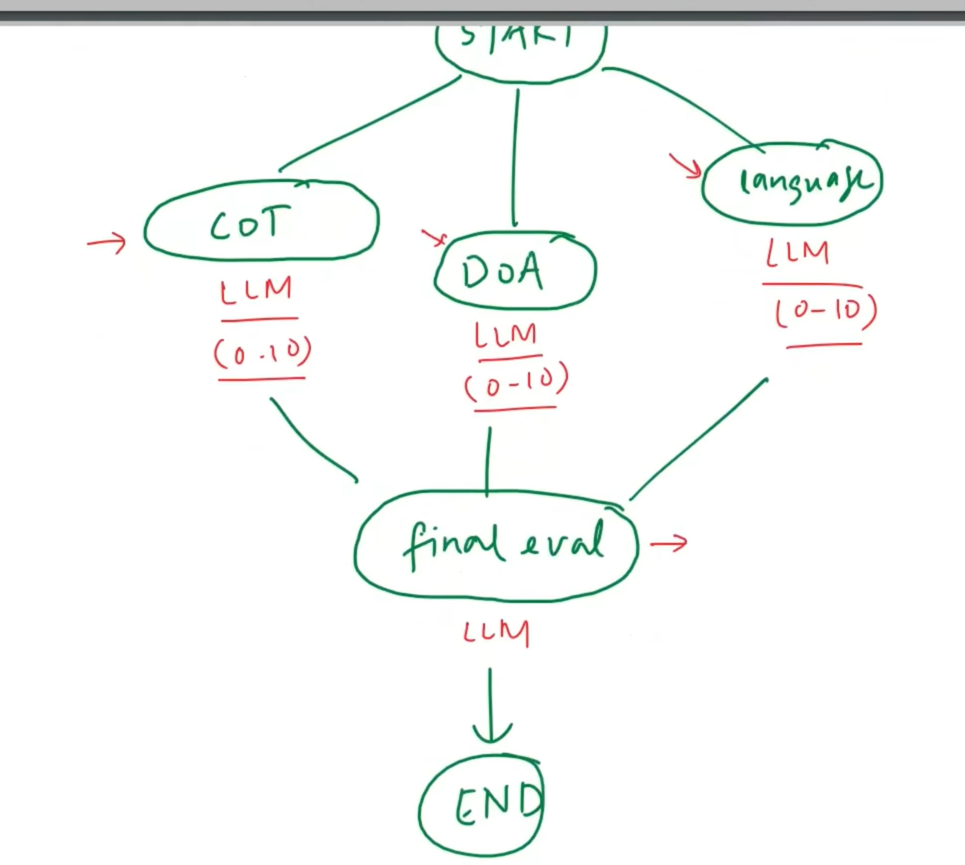

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI
import dotenv
dotenv.load_dotenv()
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [2]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback for the essay")
    score: int = Field(description="Score out of 10", ge=0, le=10)

In [3]:
structured_model = model.with_structured_output(EvaluationSchema)

In [4]:
prompt = """You are an expert essay evaluator.
Evaluate the following essay and provide detailed feedback along with a score out of 10. \n## The Future of Artificial Intelligence: A Double-Edged Sword?

Imagine a world where your commute vanishes, replaced by productive work or leisure time in a self-driving car. Envision doctors diagnosing diseases with pinpoint accuracy thanks to AI-powered image analysis. This future, powered by Artificial Intelligence (AI), is closer than you think. But are we ready for it?

Artificial Intelligence, simply put, is the ability of machines to mimic human intelligence – to learn, reason, and solve problems. It's no longer science fiction; it's rapidly transforming our world.

The future of AI holds immense potential for progress across various sectors, but it also presents significant ethical, societal, and economic challenges that require careful consideration and proactive solutions. This blog post will explore the current state of AI, emerging trends, potential benefits, and the crucial ethical considerations that will shape its trajectory.

**I. Current State of AI: Where Are We Now?**

AI is already woven into the fabric of our daily lives. It powers the search engines we use, the recommendations we receive, and the spam filters that protect our inboxes. But what exactly is driving this revolution?

*   **Machine Learning (ML):** At its core, ML allows computers to learn from data without explicit programming. Think of your email spam filter: it learns to identify spam based on patterns in your inbox, constantly improving its accuracy.
*   **Deep Learning (DL):** A subset of ML, DL uses artificial neural networks with multiple layers to analyze complex data. This is the engine behind breakthroughs in image recognition, enabling AI to "see" and understand images with remarkable accuracy.
*   **Natural Language Processing (NLP):** NLP empowers computers to understand and process human language. Chatbots, language translation tools, and sentiment analysis all rely on NLP to bridge the communication gap between humans and machines.
*   **Computer Vision:** This field allows AI to "see" the world through image and video analysis. From facial recognition to object detection, computer vision is used in applications ranging from security systems to autonomous vehicles.
*   **Robotics:** The integration of AI with physical robots is transforming industries. Robots are becoming more sophisticated, capable of performing complex tasks in manufacturing, logistics, and even surgery.

AI is making a significant impact across various industries:

*   **Healthcare:** AI is assisting in diagnostics, accelerating drug discovery, and enabling personalized medicine.
*   **Finance:** AI is used for fraud detection, algorithmic trading, and risk assessment, improving efficiency and security.
*   **Transportation:** Self-driving cars are becoming a reality, and AI is optimizing traffic management to reduce congestion.
*   **Manufacturing:** Automation, predictive maintenance, and quality control are all being revolutionized by AI, increasing productivity and reducing costs.
*   **Retail:** AI is personalizing shopping experiences, optimizing inventory management, and improving customer service.
...

We must actively shape the future of AI by prioritizing responsible development, ethical guidelines, and open dialogue. It's our collective responsibility to ensure that AI serves humanity's best interests.

As we stand on the cusp of this AI revolution, the crucial question remains: How can we ensure that AI empowers us all, rather than exacerbating existing inequalities and creating new ones? The answer lies in our commitment to responsible innovation and a shared vision for a future where AI benefits humanity as a whole.
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings..."""

In [8]:
response = structured_model.invoke(prompt)
print(response.json())


{"feedback":"The essay provides a good overview of AI, its current state, and potential future. It covers a range of relevant topics and uses clear language. However, it could benefit from more in-depth analysis and specific examples to support its claims. The ethical considerations are mentioned but not explored in sufficient detail. The conclusion is somewhat generic and could be strengthened with a more concrete call to action or a more insightful summary of the key challenges and opportunities.","score":7}


C:\Users\abhin\AppData\Local\Temp\ipykernel_62044\1269186861.py:2: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  print(response.json())


In [12]:
class UPSEState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [13]:
def evaluate_language(state: UPSEState):

    prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'language_feedback': output.feedback, 'individual_scores': [output.score]}

In [14]:
def evaluate_analysis(state: UPSEState):
  
    prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'analysis_feedback': output.feedback, 'individual_scores': [output.score]}

In [15]:

def evaluate_thought(state: UPSEState):

    prompt = f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'clarity_feedback': output.feedback, 'individual_scores': [output.score]}

In [18]:
def final_evaluation(state: UPSEState):

    # summary feedback
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    overall_feedback = model.invoke(prompt).content

    # avg calculate
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [20]:
graph = StateGraph(UPSEState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)

graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow_model = graph.compile()

In [22]:
initial_state ={
  "essay": prompt
}

workflow_model.invoke(initial_state)

{'essay': 'You are an expert essay evaluator.\nEvaluate the following essay and provide detailed feedback along with a score out of 10. \n## The Future of Artificial Intelligence: A Double-Edged Sword?\n\nImagine a world where your commute vanishes, replaced by productive work or leisure time in a self-driving car. Envision doctors diagnosing diseases with pinpoint accuracy thanks to AI-powered image analysis. This future, powered by Artificial Intelligence (AI), is closer than you think. But are we ready for it?\n\nArtificial Intelligence, simply put, is the ability of machines to mimic human intelligence – to learn, reason, and solve problems. It\'s no longer science fiction; it\'s rapidly transforming our world.\n\nThe future of AI holds immense potential for progress across various sectors, but it also presents significant ethical, societal, and economic challenges that require careful consideration and proactive solutions. This blog post will explore the current state of AI, emerg